# Spatial comparisons
---  
*J. Michelle Hu  
University of Utah  
Updated Nov 2024*  


In [61]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [62]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [63]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [64]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/NWM_datasets_proj4.txt"

In [65]:
# Basin-specific variables
basin = 'blue'
# basin = 'animas'
# basin = 'yampa'


run_aso = True
if basin == 'yampa':
    run_aso = False

# Select just for all variable output of time decay
basindirs = h.fn_list(workdir, f'*{basin}*/wy*/{basin}*/')
_ = [print(b) for b in basindirs]
# Get the WY from the directory name - assumes there is only one WY per basin right now
WYs = [int(basindir.split('wy')[1][:4]) for basindir in basindirs]
WYs = np.unique(WYs)

if len(WYs) > 1:
    print(f'Multiple water years in {basin} basin: {WYs}')
elif len(WYs) == 0:
    print(f'No water years detected in {basin} basin')

WY = WYs[0]
print(WY)

# Adjust basin dirs based on WY
basindirs = h.fn_list(workdir, f'{basin}*/wy{WY}/{basin}*/')

# Figure out filenames
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
print(poly_fn)

/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m/
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo/
2019
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


In [66]:
def clean_axes(ax, ticksoff=True, labelsoff=True, gridon=True, fc='k', aspect='equal'):
    if ticksoff:
        ax.set_xticks([])
        ax.set_yticks([])
    if labelsoff:
        ax.set_xlabel('')
        ax.set_ylabel('')
    if fc is not None:
        ax.set_facecolor(fc)
    if gridon:
        ax.grid(True)
    ax.set_aspect(aspect)

# Pull ASO to determine dates for models:  
- iSnobal  
- UA  
- NWM 
  
Slice differences by elevation (resampled to comparison datasets (ASO, UA, NWM)

In [67]:
state = 'CO'
basinname = basin.capitalize()
ending = 'depth'
inputvar = '_snowdepth'

# basinname = 'USCOBR'
# ending = ''
# inputvar = '.'
basinname, ending, inputvar

('Blue', 'depth', '_snowdepth')

In [68]:
if run_aso:
    # Water year collections should all be post January so this should work
    aso_depth_fns = h.fn_list(aso_dir, f'{state}/*{basinname}*{WY}*{ending}*tif')

    # Load depth arrays and squeeze out single dimensions
    aso_depth_list = [np.squeeze(xr.open_dataset(fn)) for fn in aso_depth_fns]

    # Rename band_data to descriptive snow_depth
    aso_depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in aso_depth_list]

    # Deal with adding time input for ASO data
    aso_depth_list = [np.squeeze(proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar))) for ds, fn in zip(aso_depth_list, aso_depth_fns)]

    _ = [print(f) for f in aso_depth_fns]

/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_BlueRiver_Mosaic_2019Apr19_snowdepth_50m.tif
/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_BlueRiver_Mosaic_2019June24-28_snowdepth_50m.tif


In [69]:
# basinname = 'USCOBR'
# ending = ''

# if run_aso:
#     # Water year collections should all be post January so this should work
#     aso_depth_fns = h.fn_list(aso_dir, f'{state}/*{basinname}*{WY}*{ending}*tif')

#     # Load depth arrays and squeeze out single dimensions
#     older_aso_depth_list = [np.squeeze(xr.open_dataset(fn)) for fn in aso_depth_fns]

#     # Rename band_data to descriptive snow_depth
#     older_aso_depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in older_aso_depth_list]

#     # Deal with adding time input for ASO data
#     inputvar = '.'

#     older_aso_depth_list = [np.squeeze(proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar))) for ds, fn in zip(older_aso_depth_list, aso_depth_fns)]

#     _ = [print(f) for f in aso_depth_fns]

# for new, old in zip(aso_depth_list, older_aso_depth_list):
#     fig, ax = plt.subplots()
#     (new - old)['snow_depth'].plot.imshow(ax=ax, vmin=-1, vmax=1, cmap='RdYlBu')

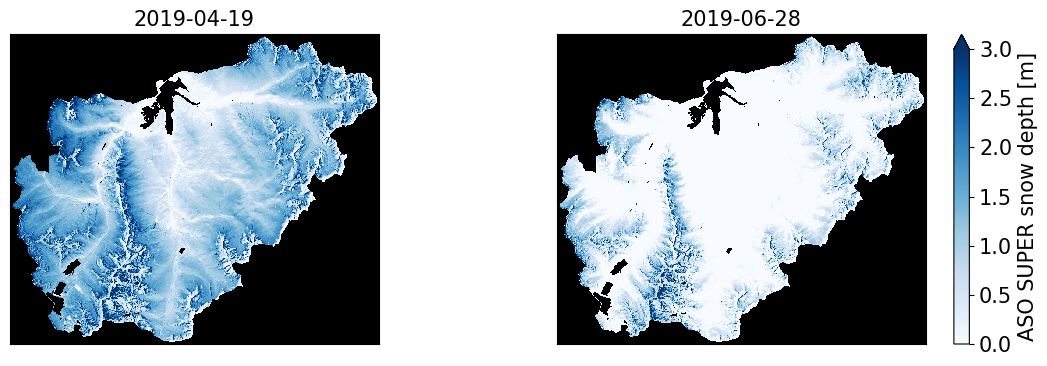

In [70]:
if run_aso:
    cmap = 'Blues'
    titles = [pd.to_datetime(depth.time.values).strftime('%Y-%m-%d') for depth in aso_depth_list]
    cbaron = [False, True]
    figsize = (12,4)
    vmin = 0
    vmax = 3

    # Plot the iSnobal snow depths 
    fig, axa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
    for jdx, depth in enumerate(aso_depth_list):
        depth['snow_depth'].plot.imshow(ax=axa[jdx], cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
        ax = axa[jdx]
        clean_axes(ax)
        # ax.set_aspect('equal')
        ax.set_title(titles[jdx])
        # ax.set_facecolor('black')

    plt.tight_layout()

## iSnobal bits

In [71]:
if run_aso:
    # Get dates, could easily just pull from filenames, but this is fine
    date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in aso_depth_fns]
    date_list = [f.strftime('%Y-%m-%d') for f in date_list]
else:
    # Use input dates since no ASO for this WY - yampa
    date_list = ['2020-04-01', '2020-05-25']
date_list

['2019-04-19', '2019-06-28']

In [72]:
# Based on validation timesteps, select a time slice
ddx = 1
dt = date_list[ddx]

# convert to datetime object
dt = np.datetime64(dt)

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m//run20190628', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo//run20190628']
['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m//run20190628/snow.nc', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo//run20190628/snow.nc']


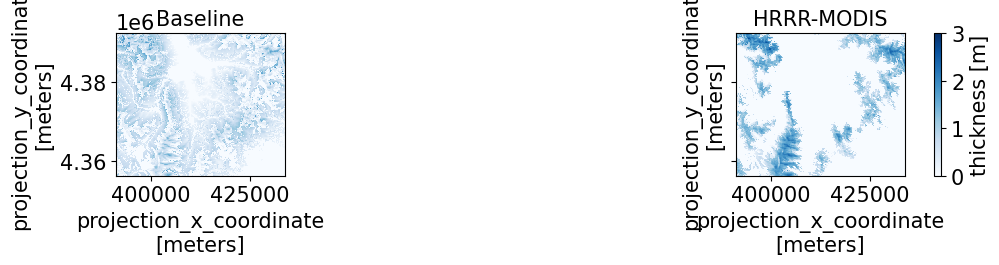

In [73]:
# find isnobal output and compare directly
isnobal_rundirs = [h.fn_list(basindir, f"run{''.join(str(dt).split('-'))}")[0] for basindir in basindirs]
print(isnobal_rundirs)

# Read in snow depths and plot
depth_fns = [proc.fn_list(sdir, "snow.nc")[0] for sdir in isnobal_rundirs]
print(depth_fns)

# Open snow depth files
depths = [np.squeeze(xr.open_mfdataset(depth_fn, decode_coords="all")['thickness']) for depth_fn in depth_fns]

# Set CRS for iSnobal output
depths = [depth.rio.write_crs('epsg:32613', inplace=True) for depth in depths]

cmap = 'Blues'
titles = ['Baseline', 'HRRR-MODIS']
cbaron = [False, True]
figsize = (12,3)
vmin, vmax = 0, 3
# Plot the iSnobal snow depths 
fig, axa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
for jdx, depth in enumerate(depths):
    depth.plot.imshow(ax=axa[jdx], cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
    ax = axa[jdx]
    ax.set_aspect('equal')
    ax.set_title(titles[jdx])

plt.tight_layout()

## NWM

+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs


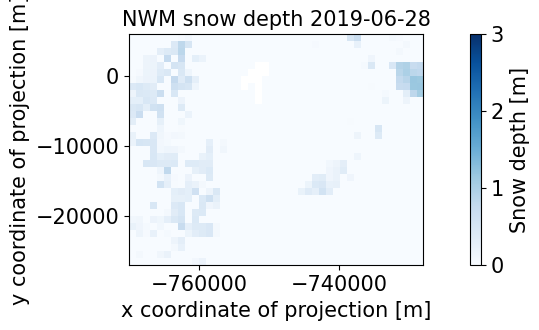

In [74]:
bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
fs = S3FileSystem(anon=True)
ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')

# Read in NWM proj4 string
with open(proj_fn, "r") as f:
    proj4 = f.read()
print(proj4)

# Read in poly_fn for spatial slicing
epsg = 'epsg:32613'
poly_gdf = gpd.read_file(poly_fn)
poly_gdf.set_crs(epsg, inplace=True, allow_override=True)

# Convert to NWM proj4 coords
poly_gdf = poly_gdf.to_crs(crs=proj4)

# Crop the dataset to the input polygon extent
var = 'SNOWH'
cropped_ds = ds.sel(x=slice(poly_gdf.bounds.minx.values[0], poly_gdf.bounds.maxx.values[0]), 
                    y=slice(poly_gdf.bounds.miny.values[0], poly_gdf.bounds.maxy.values[0]))

# Slice time from NWM spatial crop
nwm_depth = cropped_ds[var].sel(time=dt)

# Establish CRS inplace
nwm_depth = nwm_depth.rio.write_crs(input_crs=proj4, inplace=True)

# Plot the iSnobal snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
nwm_depth.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'NWM snow depth {pd.to_datetime(nwm_depth.time.values).strftime('%Y-%m-%d')}');

EPSG:32613
CPU times: user 55.3 ms, sys: 3.09 ms, total: 58.4 ms
Wall time: 59.5 ms


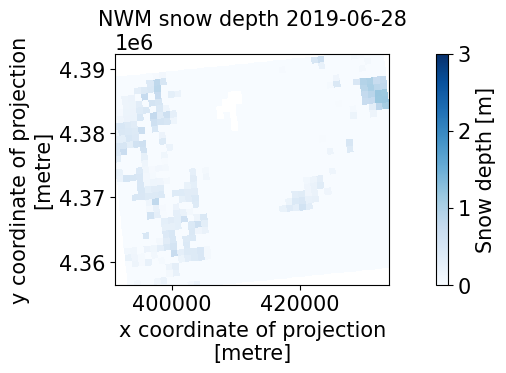

In [75]:
%%time
# Reproject to match iSnobal outputs for shared coord plotting
nwm_reproj = nwm_depth.rio.reproject_match(depth)
print(nwm_reproj.rio.crs)

# Plot the iSnobal snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
nwm_reproj.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'NWM snow depth {pd.to_datetime(nwm_depth.time.values).strftime('%Y-%m-%d')}');

## UA

/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth/4km_SWE_Depth_WY2019_v01.nc


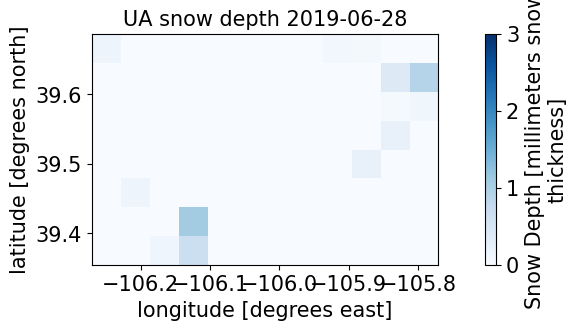

In [76]:
# Get matched UA files based on WY
ua_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth'
ua_fn = h.fn_list(ua_dir, f'*{WY}*')[0]
print(ua_fn)

# Read in matched UA dataset, dropping the SWE and time_str variables
ds = xr.open_dataset(ua_fn, drop_variables=['SWE', 'time_str'])

# Slice time
ds = ds.sel(time=dt)

# Read in poly_fn for spatial slicing
epsg = 'epsg:32613'
poly_gdf = gpd.read_file(poly_fn)
poly_gdf.set_crs(epsg, inplace=True, allow_override=True)

# Convert to UA crs
poly_gdf = poly_gdf.to_crs(crs=ds.crs.spatial_ref)

# Crop the dataset to the input polygon extent 
var = 'DEPTH'
cropped_ds = ds[var].sel(lon=slice(poly_gdf.bounds.minx.values[0], poly_gdf.bounds.maxx.values[0]), 
                    lat=slice(poly_gdf.bounds.miny.values[0], poly_gdf.bounds.maxy.values[0]))

# Establish CRS inplace
ua_depth = cropped_ds.rio.write_crs(input_crs=ds.crs.spatial_ref, inplace=True)

# Adjust units from mm SWE to m SWE
ua_depth.data = ua_depth.data / 1000

# Plot the snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
ua_depth.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'UA snow depth {pd.to_datetime(ua_depth.time.values).strftime('%Y-%m-%d')}');
ax.set_facecolor('k')

# change lat and lon to x, y
ua_depth = ua_depth.rename({'lon':'x', 'lat':'y'})

EPSG:32613
CPU times: user 42.2 ms, sys: 2.92 ms, total: 45.1 ms
Wall time: 46.7 ms


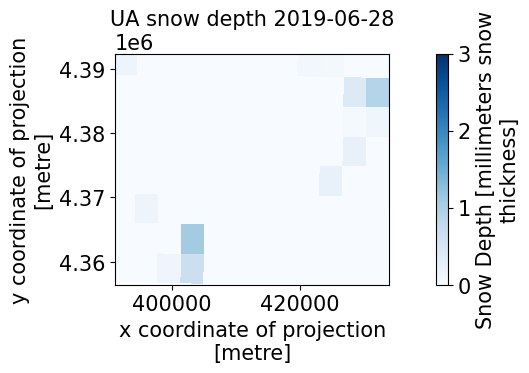

In [77]:
%%time
# Reproject to match iSnobal outputs for shared coord plotting
ua_reproj = ua_depth.rio.reproject_match(depth)
print(ua_reproj.rio.crs)

# Plot the iSnobal snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
ua_reproj.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'UA snow depth {pd.to_datetime(nwm_depth.time.values).strftime('%Y-%m-%d')}');

## Plot up all the originals

In [78]:
plot_agu = True

In [79]:
if basin == 'yampa':
    figsize = (10, 6)
    nrows, ncols = 2, 3
    arrs_original = depths + [nwm_depth] + [ua_depth]
    arrs_reproj = depths + [nwm_reproj] + [ua_reproj]
    titles = ['Baseline', 'HRRR-MODIS', 'NWM', 'ua']
else:
    figsize = (15, 6)
    nrows, ncols = 2, 5
    arrs_original = depths + [nwm_depth] + [ua_depth] + [aso_depth_list[ddx]['snow_depth']]
    arrs_reproj = depths + [nwm_reproj] + [ua_reproj] + [aso_depth_list[ddx]['snow_depth']]
    titles = ['Baseline', 'HRRR-MODIS', 'NWM', 'UA', 'ASO']

In [80]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

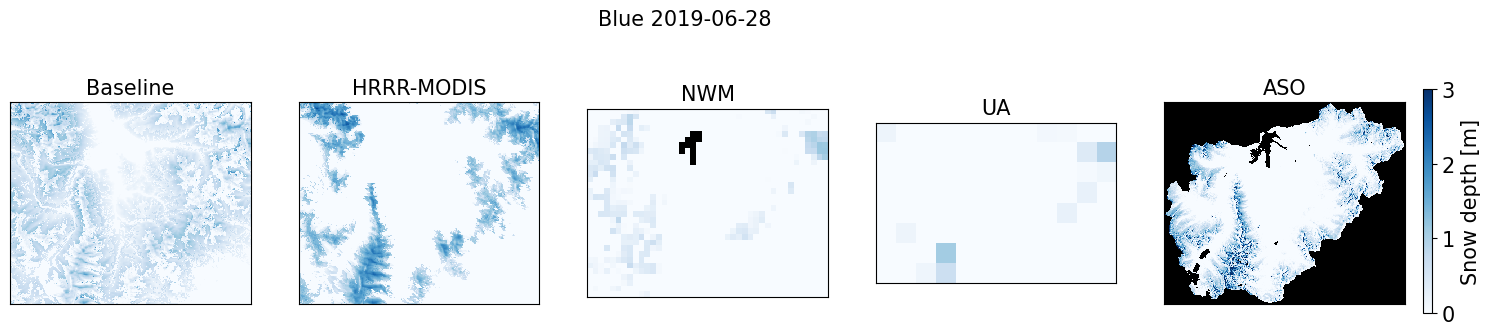

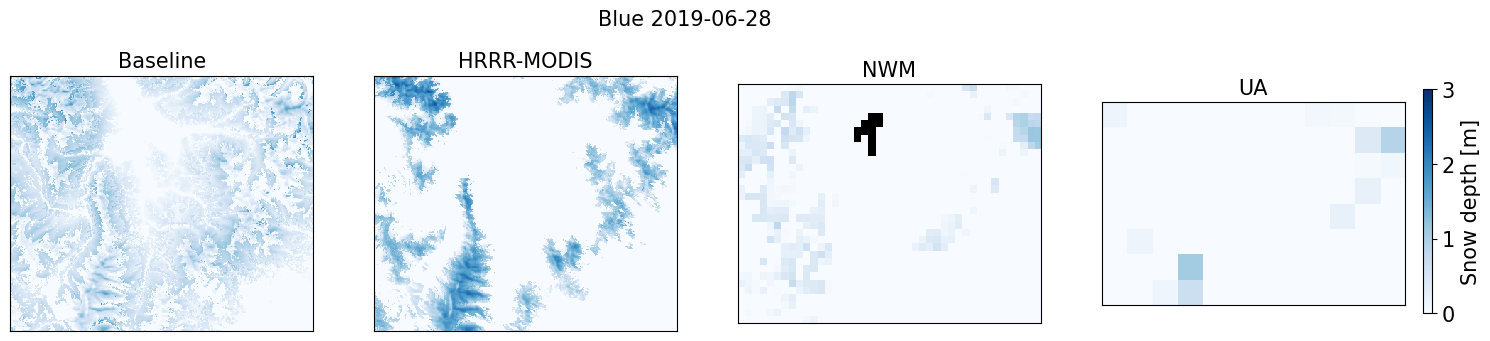

In [81]:
if basin != 'yampa':
    shift = 1
    arrs2plot = arrs_original[:-1]
    fig, axa = plt.subplots(1, len(titles), figsize=(18, 4))

    for kdx, arr in enumerate(arrs_original):
        ax = axa.flatten()[kdx]
        # arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[kdx], vmin=vmin, vmax=vmax)
        im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
        clean_axes(ax)
        ax.set_title(titles[kdx])
        # add a new colorbar using separate fig axis
        if kdx == len(arrs_original) - 1:
            # cb_ax = fig.add_axes([0.91, 0.22, 0.01, 0.56])
            cb_ax = fig.add_axes([0.91, 0.22, 0.005, 0.56])
            fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
        
    plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');
else:
    shift = 0
    arrs2plot = arrs_original

# Plot without ASO
fig, axa = plt.subplots(1, len(titles)-shift, figsize=(18, 4))

for kdx, arr in enumerate(arrs2plot):
    ax = axa.flatten()[kdx]
    # arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[kdx], vmin=vmin, vmax=vmax)
    im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
    clean_axes(ax)
    ax.set_title(titles[kdx])
    # add a new colorbar using separate fig axis
    if kdx == len(arrs_original) - shift - 1:
        cb_ax = fig.add_axes([0.91, 0.22, 0.005, 0.56])
        fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
    
plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');


In [82]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## And the reprojected arrays

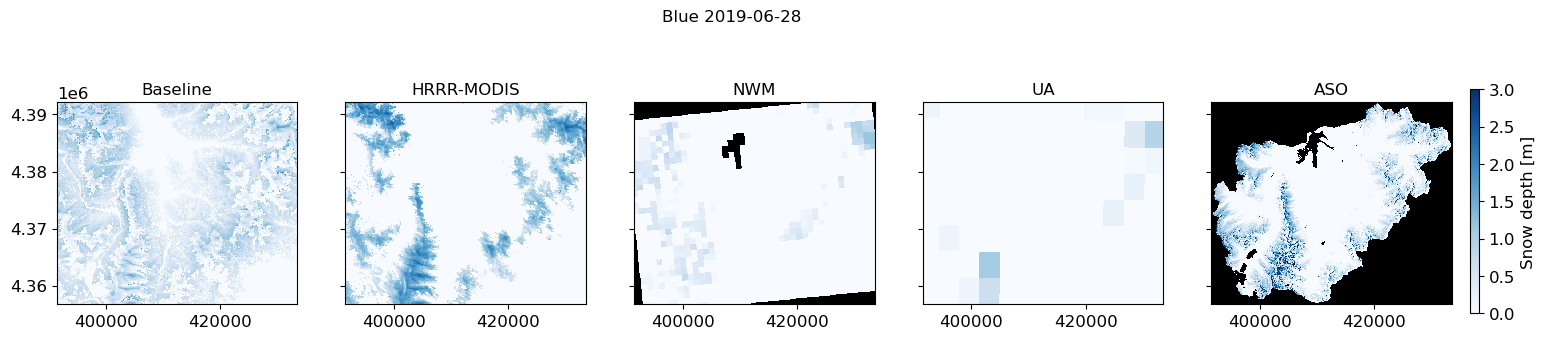

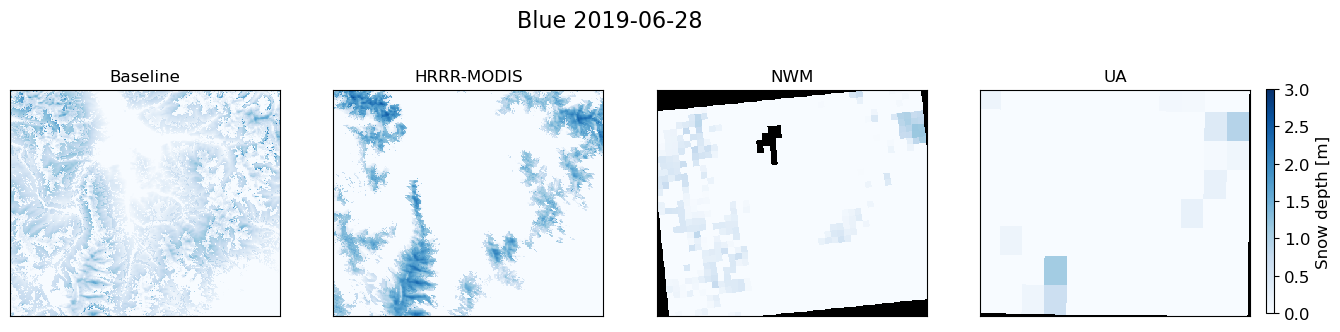

In [83]:
if basin != 'yampa':
    shift = 1
    arrs2plot = arrs_reproj[:-1]
    fig, axa = plt.subplots(1, len(titles), figsize=(18, 4), sharex=True, sharey=True)

    for kdx, arr in enumerate(arrs_reproj):
        ax = axa.flatten()[kdx]
        im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(titles[kdx])
        ax.set_aspect('equal');
        ax.set_facecolor('k');
        # add a new colorbar using separate fig axis
        if kdx == len(arrs_reproj) - 1:
            cb_ax = fig.add_axes([0.91, 0.22, 0.005, 0.56])
            fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
        
    plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');

else:
    shift = 0
    arrs2plot = arrs_reproj

fig, axa = plt.subplots(1, len(titles)-shift, figsize=(16, 4), sharex=True, sharey=True)

for kdx, arr in enumerate(arrs2plot):
    ax = axa.flatten()[kdx]
    # arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[kdx], vmin=vmin, vmax=vmax)
    im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
    clean_axes(ax)
    ax.set_title(titles[kdx])
    # add a new colorbar using separate fig axis
    if kdx == len(arrs_reproj) - shift - 1:
        cb_ax = fig.add_axes([0.91, 0.22, 0.005, 0.56])
        fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
    
plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}', fontsize=16);

In [84]:
# Determine if continuing with original or reprojected data
original = False
if original:
    arrs = arrs_original
else:
    arrs = arrs_reproj

## Plot it all up

In [85]:
import seaborn as sns
sns.set_palette('icefire')

In [86]:
from rasterio.enums import Resampling

(360, 428)
(360, 428)
(360, 428)
(360, 428)


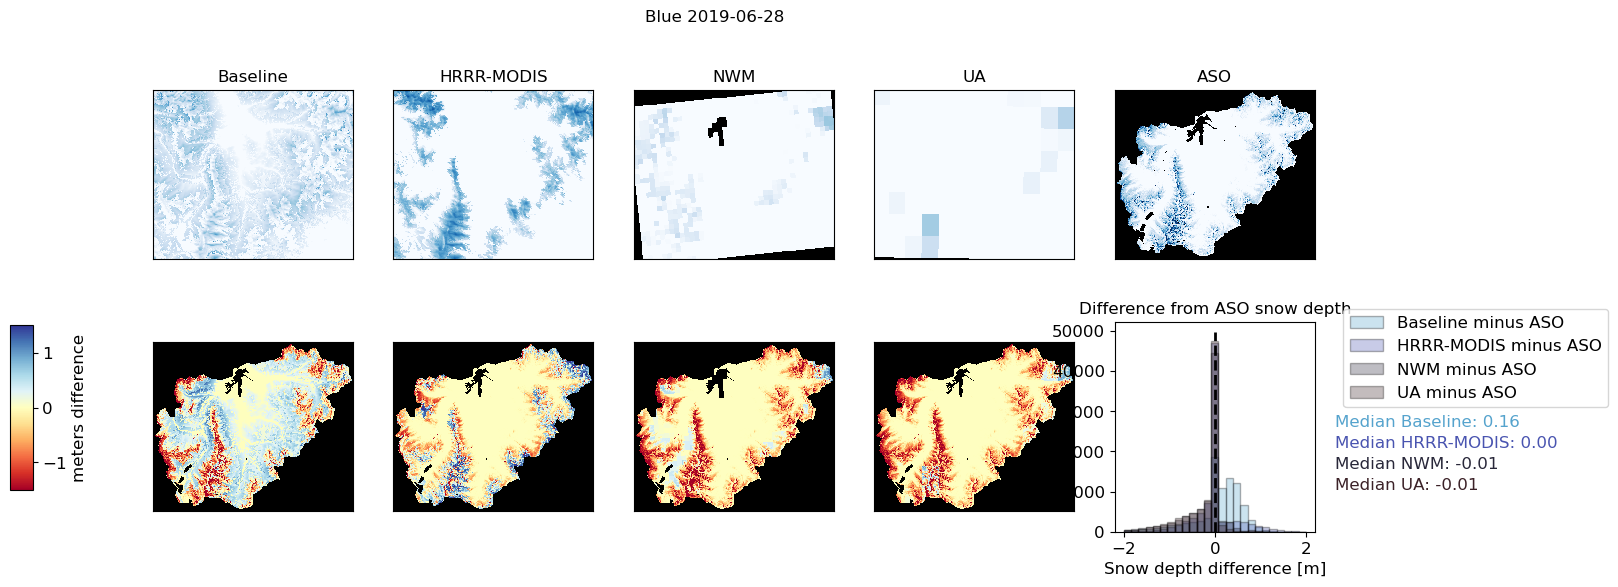

In [87]:
if run_aso:
    nbins = 25
    alpha = 0.3
    ec = 'k'
    binrange = (-2, 2)
    ys = [0.5, 0.4, 0.3, 0.2]
        
    if original:
        fig, axa = plt.subplots(nrows, ncols, figsize=figsize)
    else:
        fig, axa = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for kdx, arr in enumerate(arrs):
        ax = axa.flatten()[kdx]
        im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
        clean_axes(ax)
        ax.set_title(titles[kdx])
        # # add a new colorbar using separate fig axis
        # if kdx == len(arrs) - 1:
        #     cb_ax = fig.add_axes([0.03, 0.18, 0.015, 0.274])
        #     fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
        
    plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');    
    aso_reproj_list = []
    arrs_aso_clipped = []
    diff_dict = dict()
    for ldx, arr in enumerate(arrs):
        ax = axa.flatten()[ldx + kdx + 1]
        if ldx < len(arrs) - 1:

            # Reproject and match ASO to comparison array
            aso_reproj = arrs[-1].rio.reproject_match(arr, resampling=Resampling.average)
            print(aso_reproj.shape)

            # store this in a list for later
            aso_reproj_list.append(aso_reproj)
            
            # Compute diff
            diff = arr - aso_reproj

            # Compute the original array, but clipped to the ASO extent by adding ASO back in
            arrs_aso_clip = diff + aso_reproj
            arrs_aso_clipped.append(arrs_aso_clip)

            # Store in dict
            diff_dict[titles[ldx]] = diff

            # Plot the diff
            diff_im = diff.plot.imshow(ax=ax, cmap='RdYlBu', add_colorbar=False, vmin=-vmax/2, vmax=vmax/2)
        
        if ldx == len(arrs) - 2:
            cb_ax = fig.add_axes([0.03, 0.18, 0.015, 0.274])
            fig.colorbar(diff_im, orientation='vertical',cax=cb_ax, label='meters difference')

        clean_axes(ax)
        ax.set_title('')
        if ldx == len(arrs) - 1:
            # Turn off existing axes that have shared coords
            ax.set_visible(False)
            
            # Add a brand new one to plot difference histograms
            ax = fig.add_subplot(nrows, ncols, nrows*ncols)
            for mdx, f in enumerate(diff_dict.keys()):
                med = np.nanmedian(diff_dict[f])
                diff_dict[f].plot.hist(range=binrange, bins=nbins, alpha=alpha, ec=ec, label=f'{f} minus ASO')
                ax.annotate(f'Median {f}: {med:.2f}', xycoords='axes fraction',
                            xy=(1.1, ys[mdx]),
                            ha='left', color=sns.color_palette()[mdx]
                        )
            ax.vlines(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
            ax.set_title('Difference from ASO snow depth')
            ax.set_xlabel('Snow depth difference [m]')
            ax.legend(bbox_to_anchor=(1.1, 1.1))          
            break

    # plt.tight_layout()

## This is how to calculate volume for NWM and UA properly

In [88]:
if original:
    pix_res_list = [100, 100, 1000, 4000, 50]
    arrs2calc = arrs_aso_clipped + [aso_depth_list[ddx]['snow_depth']]

    for pix_res, arr in zip(pix_res_list, arrs2calc):
        flat_arr = arr.values.flatten()
        flat_arr = flat_arr[~np.isnan(flat_arr)]
        volume = pix_res ** 2 * flat_arr # per-pixel volume = per-pixel area * per-pixel depth
        total_volume = volume.sum()
        print(f'{arr.size}, {total_volume / 1e6:.0f} km^3')
        # print(f'{flat_arr.sum()*pix_res**2 / 1e6:.0f} km^3')

## Plot histograms of differences

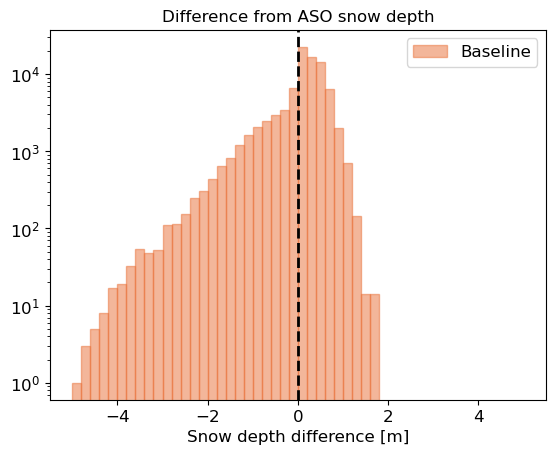

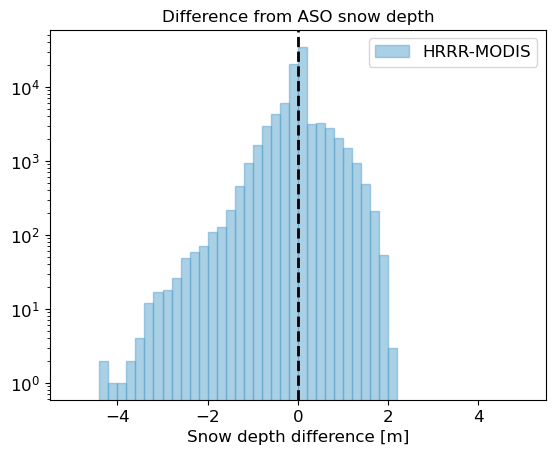

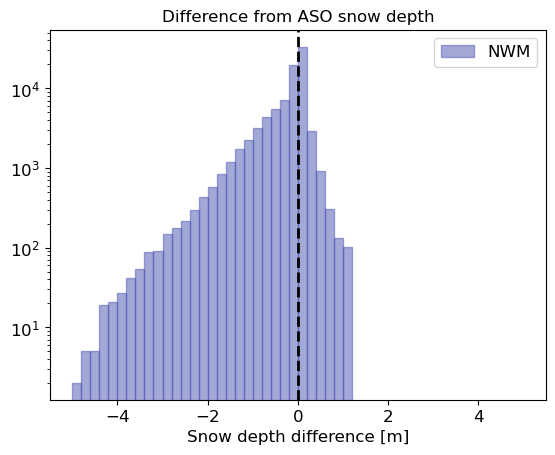

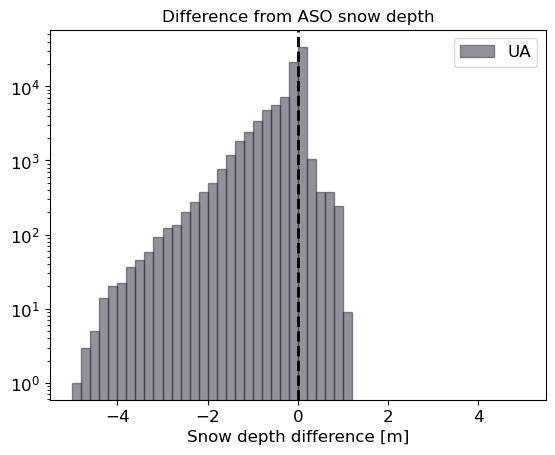

In [89]:
nbins = 50
alpha = 0.5
ec = 'k'
binrange = (-5, 5)
xs = [1.5, -1, -1.5]
ys = [12000, 10000, 6000]

if run_aso:
    # fig, ax = plt.subplots()
    for ldx, f in enumerate(diff_dict.keys()):
        # if ldx > 0:
        fig, ax = plt.subplots()
        med = np.nanmedian(diff_dict[f])
        diff_dict[f].plot.hist(range=binrange, bins=nbins, alpha=alpha, ec=sns.color_palette()[ldx-1], 
                                facecolor=sns.color_palette()[ldx-1],
                                # histtype='step', 
                                label=f)#label=f'{f}: ${med:.2f}$')
        # ax.annotate(f'Median {f}: {med:.2f}', 
        #             xy=(-0.75, ys[ldx]),
        #             ha='right', color=sns.color_palette()[ldx]
        #             # xy=(xs[ldx], 8000)
        #             # xy=(med*3, ys[ldx])
        #            )

        plt.axvline(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
        plt.title('Difference from ASO snow depth')
        plt.xlabel('Snow depth difference [m]')
        plt.legend()
        plt.yscale('log');

n=66348
median: 0.46
median ref: 0.33
n=28326
median: 1.04
median ref: 0.33
n=17588
median: 0.29
median ref: 0.33
n=13141
median: 0.22
median ref: 0.33


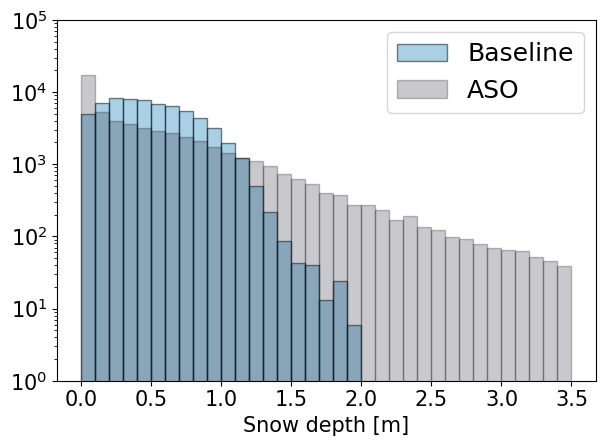

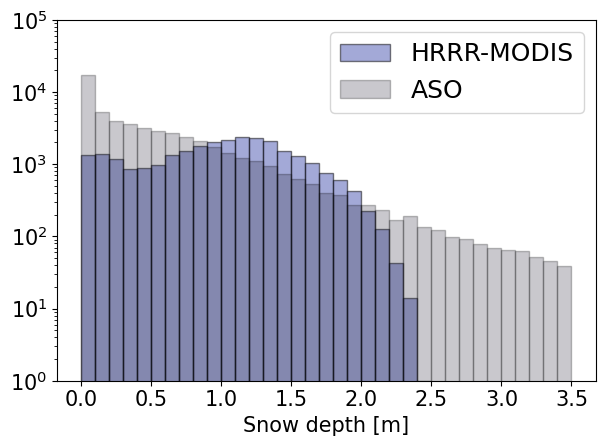

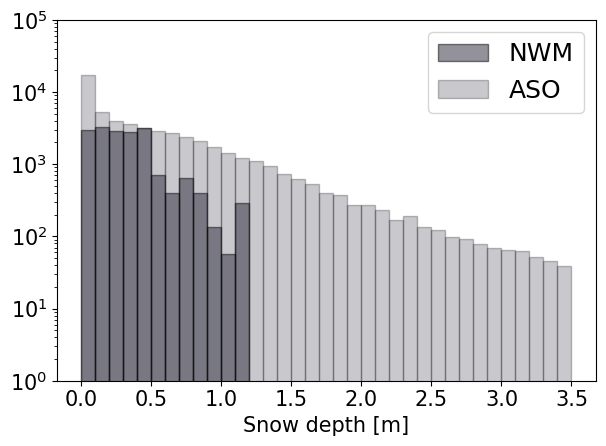

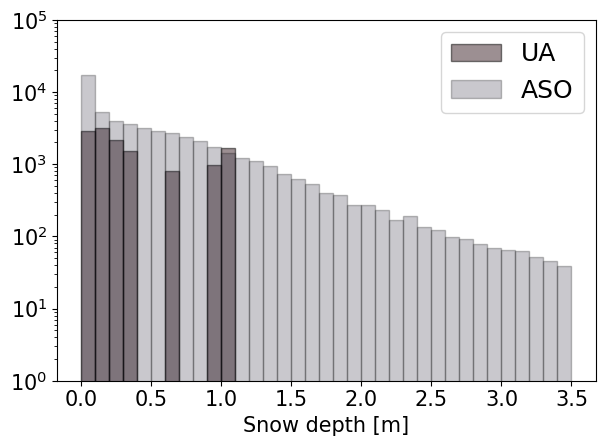

In [90]:

# Plot nonzero snow depth distribution

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

binrange = (0, 3.5)
nbins = 35
thresh = 0
# nonzeroref = np.ravel(arrs[-1])
# nonzeroref = nonzeroref[nonzeroref>thresh]
isnobalcolors = ['mediumblue', 'cornflowerblue']
nwm_color = 'salmon'#'tomato'
ua_color = 'goldenrod'#'tomato'
facecolors = [isnobalcolors[1], nwm_color, ua_color]

# for ldx, arr in enumerate(arrs[1:-1]):
# for ldx, arr in enumerate(arrs[:-1]):
# Clip to ASO area for fair comparison!
for ldx, arr in enumerate(arrs_aso_clipped):
    fig, ax = plt.subplots()
    nonzeroarr = np.ravel(arr)
    nonzeroarr = nonzeroarr[nonzeroarr>thresh]
    # note number of pixels
    print(f'n={nonzeroarr.size}')
    # note median value
    print(f'median: {np.median(nonzeroarr):.2f}')
    
    ax.hist(nonzeroarr, range=binrange, bins=nbins, alpha=alpha, ec=ec, label=titles[ldx], facecolor=sns.color_palette()[ldx])
    # omit time decay
    # ax.hist(nonzeroarr, range=binrange, bins=nbins, alpha=alpha, ec=ec, label=titles[ldx+1], facecolor=facecolors[ldx])

    # Use each reprojected ASO set for each array
    if run_aso:
        nonzeroref = np.ravel(aso_reproj_list[ldx])
        nonzeroref = nonzeroref[nonzeroref>thresh]
        # note median reference value
        print(f'median ref: {np.median(nonzeroref):.2f}')
        # note median difference is above, cannot calculate like this unless you want the differnce of median values, 
        # but that's not really it, you want the median of the difference values
        # print(f'diff of medians: {np.median(nonzeroarr) - np.median(nonzeroref):.2f}')
        ax.hist(nonzeroref, range=binrange, bins=nbins, alpha=alpha/2, ec=ec, label='ASO', facecolor=sns.color_palette()[2])
    ax.legend()
    plt.yscale('log')
    plt.ylim(1e0, 1e5)
    # plt.axvline(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
    # plt.title('Difference from ASO snow depth')
    plt.xlabel('Snow depth [m]')
    plt.tight_layout()
    

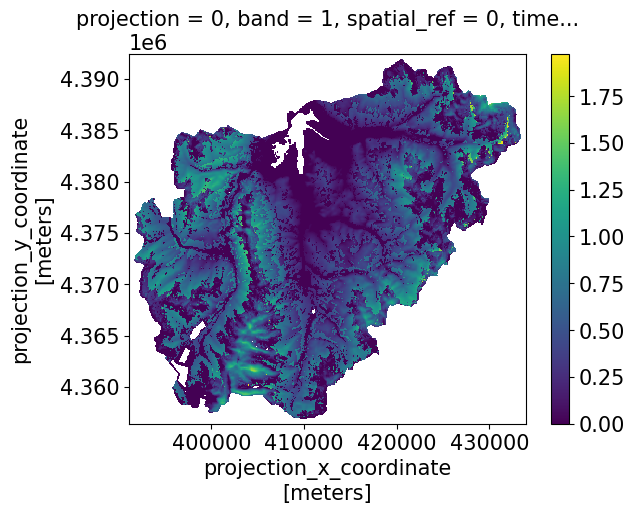

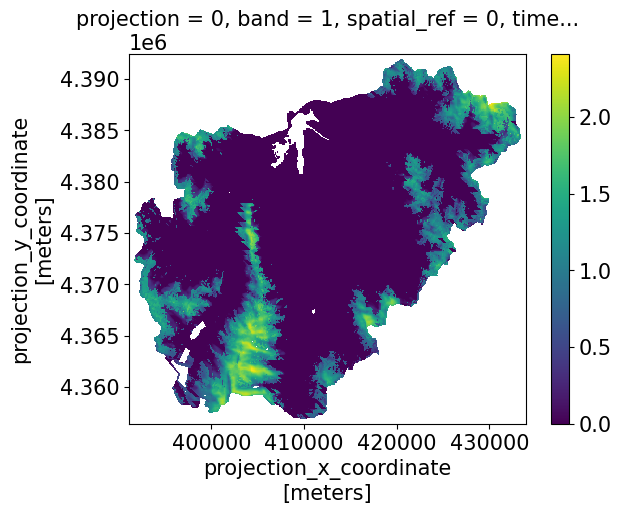

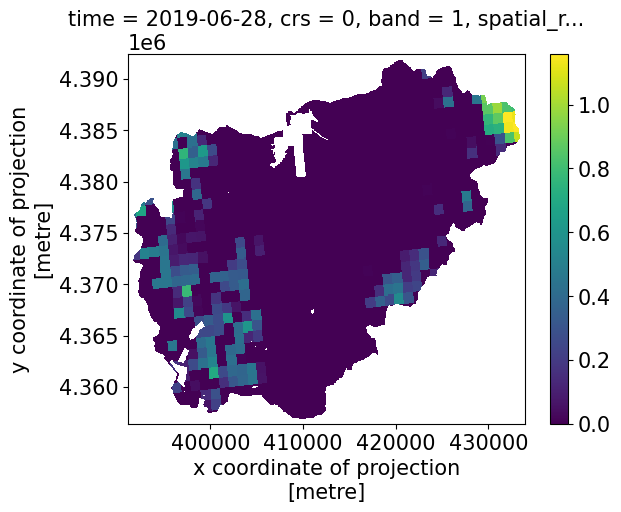

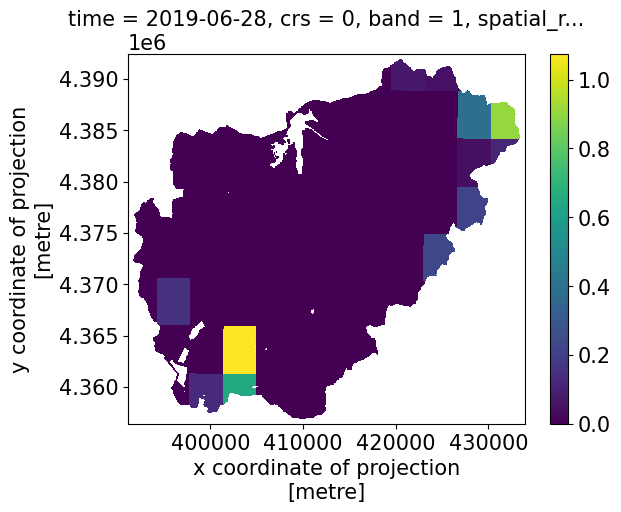

In [91]:
for f in arrs_aso_clipped:
    plt.figure()
    f.plot.imshow()


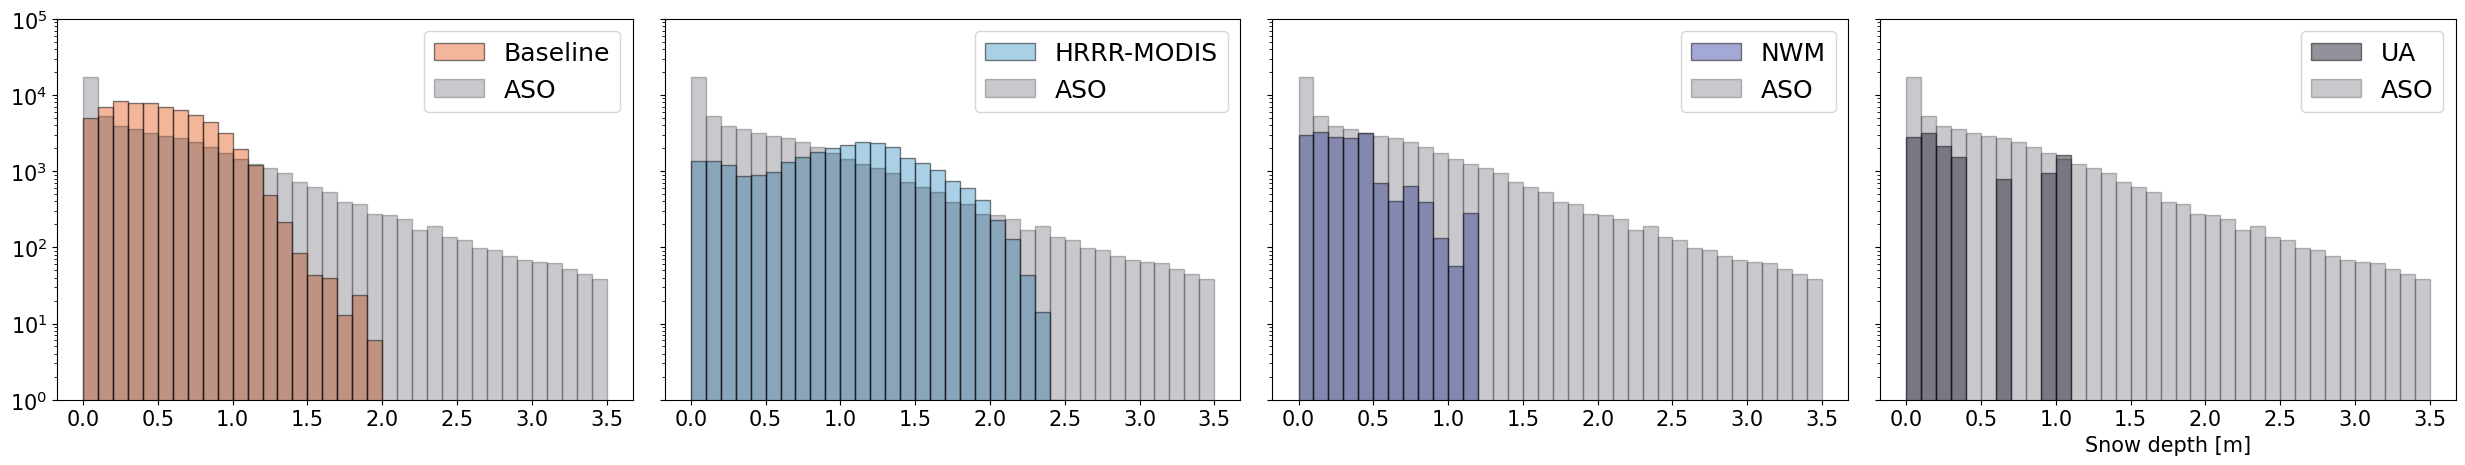

In [92]:
if run_aso:
    # Plot nonzero snow depth distribution

    binrange = (0, 3.5)
    nbins = 35
    thresh = 0
    # nonzeroref = np.ravel(arrs[-1])
    # nonzeroref = nonzeroref[nonzeroref>thresh]
    isnobalcolors = ['mediumblue', 'cornflowerblue']
    nwm_color = 'salmon'#'tomato'
    ua_color = 'goldenrod'#'tomato'
    facecolors = [isnobalcolors[1], nwm_color, ua_color]
    # hist_arrs = arrs[:-1] # without time decay arrs[1:-1]
    hist_arrs = arrs_aso_clipped

    fig, axa = plt.subplots(1, len(hist_arrs), figsize=(25,5), sharex=True, sharey=True)

    for ldx, arr in enumerate(hist_arrs):
        ax = axa.flatten()[ldx]    
        nonzeroarr = np.ravel(arr)
        nonzeroarr = nonzeroarr[nonzeroarr>thresh]
        
        ax.hist(nonzeroarr, range=binrange, bins=nbins, alpha=alpha, ec=ec, label=titles[ldx], facecolor=sns.color_palette()[ldx-1])
        # omit time decay
        # ax.hist(nonzeroarr, range=binrange, bins=nbins, alpha=alpha, ec=ec, label=titles[ldx+1], facecolor=facecolors[ldx])

        # Use each reprojected ASO set for each array    
        nonzeroref = np.ravel(aso_reproj_list[ldx])
        nonzeroref = nonzeroref[nonzeroref>thresh]

        ax.hist(nonzeroref, range=binrange, bins=nbins, alpha=alpha/2, ec=ec, label='ASO', facecolor=sns.color_palette()[2])
        ax.legend()
        plt.yscale('log')
        plt.ylim(1e0, 1e5)
        # plt.axvline(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
        # plt.title('Difference from ASO snow depth')
        plt.xlabel('Snow depth [m]')
        plt.tight_layout()
        

In [93]:
if run_aso:
    for f in aso_reproj_list:
        print(f.shape)

(360, 428)
(360, 428)
(360, 428)
(360, 428)


# Plot the diffs really big in a single row

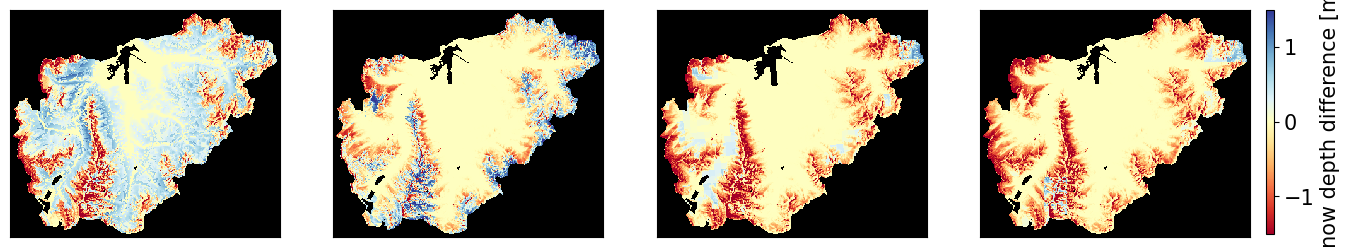

In [94]:
if run_aso:
    # Plot the diffs in a nice row
    if original:
        fig, axa = plt.subplots(1, len(diff_dict.keys()), figsize=(16,4))
    else:
        fig, axa = plt.subplots(1, len(diff_dict.keys()), figsize=(16,4), sharex=True, sharey=True)
    for mdx, f in enumerate(diff_dict.keys()):
        diff = diff_dict[f]
        title = titles[mdx]
        ax = axa.flatten()[mdx]

        # Plot the diff
        diff_im = diff.plot.imshow(ax=ax, cmap='RdYlBu', add_colorbar=False, 
                                vmin=-vmax/2, vmax=vmax/2)
        
        # add a new colorbar using separate fig axis
        if mdx == len(diff_dict.keys()) - 1:
            # set colorbar size to be same height as the plot
            cb_ax = fig.add_axes([0.91, 0.22, 0.005, 0.56])
            fig.colorbar(diff_im, orientation='vertical', cax=cb_ax, label='Snow depth difference [m]',)

        if plot_agu:
            ax.set_title('')
            clean_axes(ax)
        else:
            ax.set_title(title)
        if not plot_agu:
            plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');

## Read in terrain files (aspect, slope, elevation)

In [95]:
# switch back to reprojected arrays to keep terrain stuff straightforward for now
if original is True:
    print(f'original is {original}')
    print('Change to False in designated cell and re-run to continue notebook execution')
    raise SystemExit("Stop right there!")

In [96]:
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
terrain_fns = h.fn_list(script_dir, f'{basin}*_setup/data/*100m*.tif')
terrain_fns

['/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_aspect.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_hs.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_slope.tif']

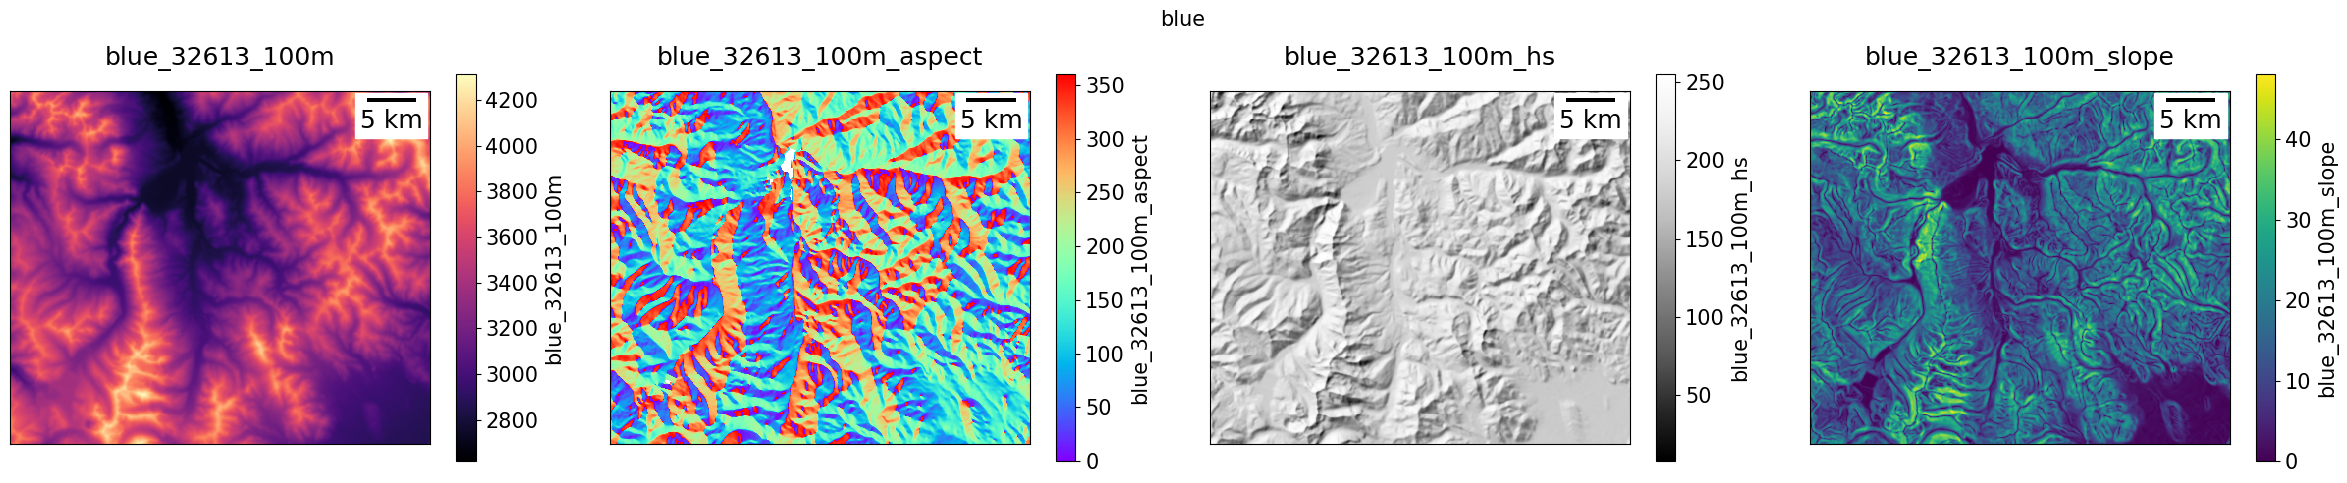

In [97]:
# Load files
terrain_list = [h.load(f) for f in terrain_fns]

# Crop to the same extent as the depth data
cropped_list = [ds.rio.reproject_match(depth) for ds in terrain_list]

# Assign individual varnames for ease of use below
dem, aspect, hs, slope = cropped_list

# Plot them up for a quick view
cmaps = ['magma', 'rainbow', 'Greys_r', 'viridis']
terraintitles = [PurePath(f).stem for f in terrain_fns]

fig, axa = plt.subplots(1, len(cropped_list), figsize=(24, 5))
for jdx, ax in enumerate(axa.flatten()):
    h.plot_one(cropped_list[jdx], cmap=cmaps[jdx], specify_ax=(fig, ax), title=terraintitles[jdx], 
               turnoffaxes=True, turnofflabels=True)
plt.suptitle(f'{basin}')
plt.tight_layout();

In [98]:
# Save these resampled arrays to a single netcdf for future use

outdir = h.fn_list(script_dir, f'{basin}*_setup/data')[0]
out_fn = f'{outdir}/{basin}_terrain.nc'                    
print(out_fn)
out_ds = xr.Dataset({
    'dem': dem,
    'aspect': aspect,
    'hs': hs,
    'slope': slope
})
out_ds.to_netcdf(out_fn)

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_terrain.nc


### Reassign and bin terrain values

In [99]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

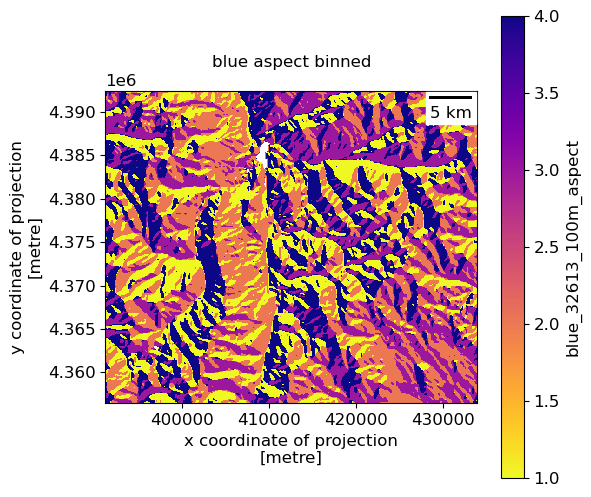

In [100]:
aspect_bin = proc.bin_aspect(aspect, basinname=basin, figsize=(6,6))

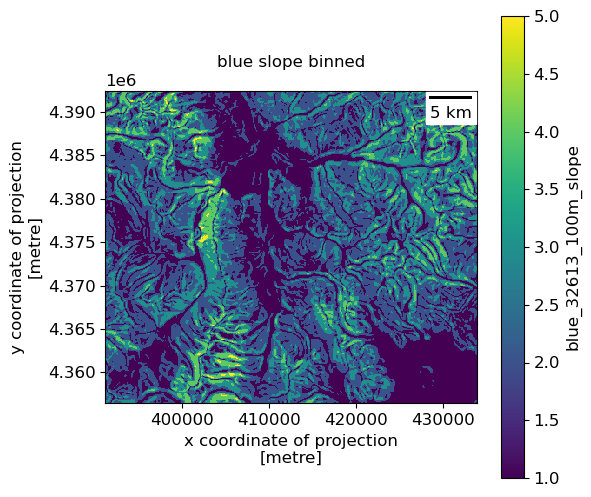

In [101]:
slope_bin = proc.bin_slope(slope, basinname=basin, figsize=(6,6))

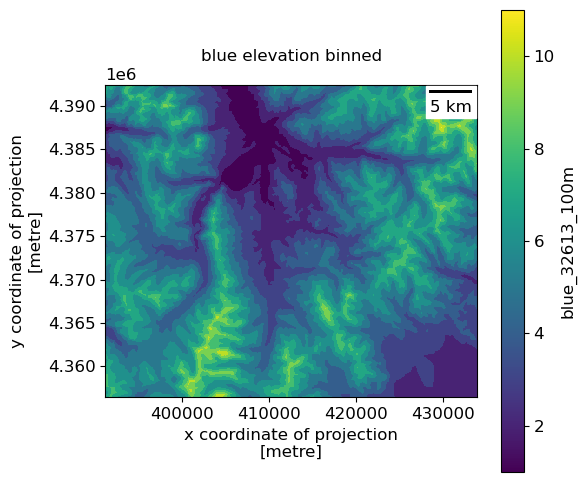

In [102]:
n_bins = 10
dem_bin, dem_elev_ranges = proc.bin_elev(dem, basinname=basin, figsize=(6,6), p=n_bins)

In [103]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


Basin area by elevation


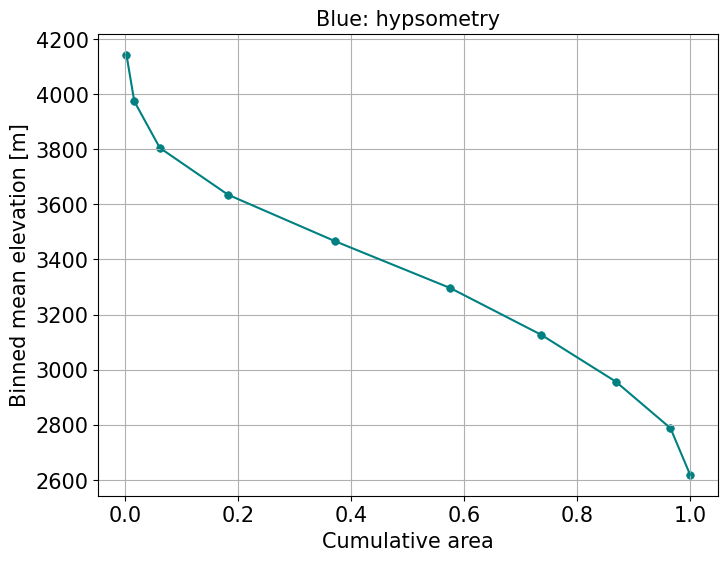

In [104]:
# bin by elevation range
# store the binned and mean values of snow depth difference for that bin in a dict
pixel_res = 100

# Also plot this up
fig, ax = plt.subplots(1, figsize=(8, 6))

print('Basin area by elevation')
mean_elevs = []
low_elevs = []
total_areas = [1] # start off with 1, as the first bin is the lowest elevation and all of the basin is higher than this
area_slices = []
basin_total = dem.size * pixel_res ** 2
for kdx, elev_range in enumerate(dem_elev_ranges):
    # Extract min and max elevations in that bin
    low, high = dem_elev_ranges[elev_range]        
    band_slice = dem.data[(dem.data>=low) & (dem.data<high)] # all pixels within this elevation band
    band_area = band_slice.size * pixel_res ** 2 # calculate area of pixels within this elevation band
    if kdx == 0:
        # cumulative sum of area, initiate as elevation band area
        running_total = band_area
    else:
        # add to running total
        running_total = running_total + band_area
    
    # calculate mean elevation of this bin for plotting
    mean_elev = (low + high) / 2
    low_elevs.append(low)
    mean_elevs.append(mean_elev)

    # append the area of this elevation band to the list
    area_slices.append(band_area)
    # append the proportion of the basin that is higher than this elevation.
    if kdx == len(dem_elev_ranges)-1:
        pass #low_elevs.append(high)
    else:
        total_areas.append(1 - running_total / basin_total)
    

area_slices = np.array(area_slices)
ax.scatter(total_areas, low_elevs, s=30, c='teal', linewidths=0.5)
ax.plot(total_areas, low_elevs, c='teal')

# ax.legend(bbox_to_anchor=(1,1));
ax.set_xlabel('Cumulative area')
# ax.set_xlabel('Relative area')
ax.set_ylabel('Binned mean elevation [m]');
ax.set_title(f'{basin.capitalize()}: hypsometry');
ax.grid(True)

In [105]:
pd.DataFrame({'low_thresh': low_elevs, 'total_areas':total_areas})

low_thresh  total_areas
0        2619     1.000000
1        2788     0.965232
2        2957     0.868322
3        3127     0.736137
4        3296     0.575675
5        3466     0.371632
6        3635     0.181678
7        3805     0.060955
8        3974     0.015693
9        4143     0.001850

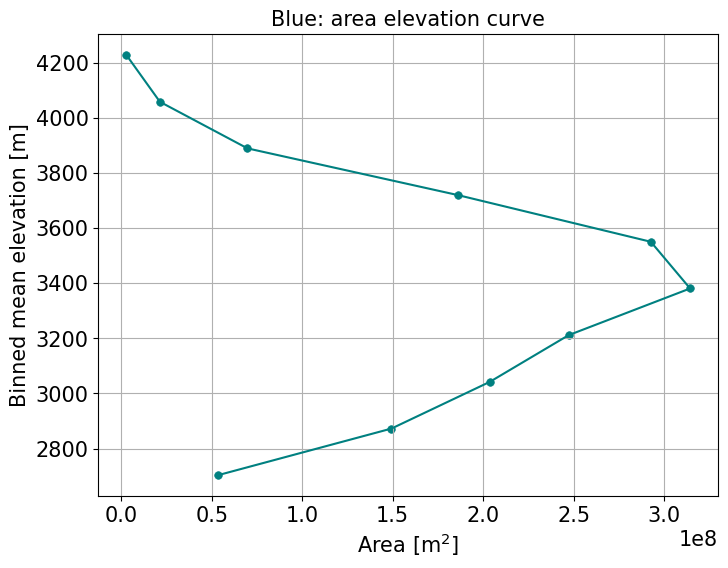

In [106]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.scatter(area_slices, mean_elevs, s=30, c='teal', linewidths=0.5)
ax.plot(area_slices, mean_elevs, c='teal')

ax.set_xlabel('Area [m$^2$]')
ax.set_ylabel('Binned mean elevation [m]');
ax.set_title(f'{basin.capitalize()}: area elevation curve');
ax.grid(True)

### Segment snow depth by terrain categories

In [107]:
titles = ['Baseline', 'HRRR-MODIS', 'NWM', 'SWANN', 'ASO']

### Difference in snow depth by aspect

In [108]:
for k in diff_dict.keys():
        print('\n', k)
        diff_arr = diff_dict[k].load()
        print(diff_arr.size)
    


 Baseline
154080

 HRRR-MODIS
154080

 NWM
154080

 UA
154080


In [109]:
if run_aso:
    # TODO
    # Add standard deviation/other measure of spread around the mean
    # Add range of means - e.g., north vs. south
    compass_rose = ['North', 'East', 'South', 'West']
    snow_depth_dict = dict()
    print('Mean depth difference by aspect')
    for k in diff_dict.keys():
        print('\n', k)
        diff_arr = diff_dict[k].load()
        for r in range(4):
            print(r)
            aspect_slice = diff_arr.data[aspect_bin.data==r+1]
            aspect_slice = aspect_slice[~np.isnan(aspect_slice)]
            mean_depth_diff = diff_arr.mean()
            print(f'{compass_rose[r]}: {aspect_slice.min():.1f}, {aspect_slice.mean():.1f}, {aspect_slice.max():.1f}')    
            snow_depth_dict[k] = (aspect_slice, f'{aspect_slice.min():.1f}, {aspect_slice.mean():.1f}, {aspect_slice.max():.1f}')

Mean depth difference by aspect

 Baseline
0
North: -4.5, 0.1, 1.5
1
East: -5.3, -0.1, 1.4
2
South: -4.8, 0.1, 1.6
3
West: -4.5, 0.2, 1.8

 HRRR-MODIS
0
North: -4.3, -0.1, 2.1
1
East: -4.0, -0.1, 2.0
2
South: -3.7, 0.1, 2.0
3
West: -4.3, 0.1, 2.0

 NWM
0
North: -4.8, -0.3, 1.1
1
East: -5.3, -0.4, 1.1
2
South: -4.8, -0.2, 1.1
3
West: -5.1, -0.1, 1.2

 UA
0
North: -4.7, -0.3, 1.0
1
East: -5.3, -0.4, 0.9
2
South: -4.8, -0.2, 1.0
3
West: -5.1, -0.1, 1.1


### Plot by Elevation

In [110]:
if run_aso:
    # bin by elevation range
    # store the binned and mean values of snow depth difference for that bin in a dict

    elev_dict = dict()

    print('Mean depth difference by elevation')
    for k in diff_dict.keys():
        print('\n', k)
        diff_arr = diff_dict[k].load()

        for elev_range in dem_elev_ranges:
            # Extract min and max elevations in that bin
            low, high = dem_elev_ranges[elev_range]
            elev_slice = diff_arr.data[(dem.data>=low) & (dem.data<high)]        
            elev_slice = elev_slice[~np.isnan(elev_slice)]
            mean_diff = elev_slice.mean()

            print(f'{low, high}: {elev_slice.min():.1f} || {elev_slice.mean():.1f}, {np.nanmedian(elev_slice):.1f} || {elev_slice.max():.1f}')    
                
            elev_dict[f'{k}_{low}_{high}'] = (elev_slice, f'{elev_slice.min():.1f} || {elev_slice.mean():.1f}, {np.nanmedian(elev_slice):.1f} || {elev_slice.max():.1f}')

Mean depth difference by elevation

 Baseline
(2619, 2788): 0.0 || 0.0, 0.0 || 0.2
(2788, 2957): -0.0 || 0.1, 0.0 || 0.7
(2957, 3127): -1.9 || 0.2, 0.2 || 1.0
(3127, 3296): -4.0 || 0.4, 0.4 || 1.3
(3296, 3466): -2.6 || 0.4, 0.4 || 1.5
(3466, 3635): -4.5 || -0.1, -0.0 || 1.7
(3635, 3805): -5.3 || -0.7, -0.5 || 1.8
(3805, 3974): -4.8 || -0.5, -0.3 || 1.7
(3974, 4143): -4.5 || -0.2, 0.0 || 1.3
(4143, 4313): -2.5 || 0.2, 0.4 || 1.2

 HRRR-MODIS
(2619, 2788): 0.0 || 0.0, 0.0 || 0.0
(2788, 2957): -0.0 || -0.0, 0.0 || 0.0
(2957, 3127): -1.9 || -0.0, 0.0 || 0.0
(3127, 3296): -4.3 || -0.0, 0.0 || 1.0
(3296, 3466): -3.1 || -0.2, -0.1 || 1.4
(3466, 3635): -4.0 || -0.1, -0.1 || 1.7
(3635, 3805): -4.0 || 0.2, 0.3 || 1.9
(3805, 3974): -4.3 || 0.4, 0.6 || 2.1
(3974, 4143): -3.4 || 0.7, 0.9 || 2.0
(4143, 4313): -1.5 || 1.1, 1.3 || 2.0

 NWM
(2619, 2788): 0.0 || 0.0, 0.0 || 0.0
(2788, 2957): -0.0 || -0.0, 0.0 || 0.0
(2957, 3127): -1.9 || 0.0, 0.0 || 0.5
(3127, 3296): -4.3 || 0.0, 0.0 || 0.7
(3296, 3466

In [111]:
def plotit(dem_elev_ranges: dict, clip_arr: xr.DataArray, dem: xr.DataArray, pixel_res=None, label='label', markerstyle='P', depths=True):
    '''Plot the snow depth data binned by elevation range, with optional pixel resolution for volume calculations.
    Parameters:
    dem_elev_ranges: dict
        Dictionary of elevation ranges to bin the data
    clip_arr: xarray.DataArray
        Array to plot
    dem: xarray.DataArray
        DEM data for the basin
    pixel_res: float
        Pixel resolution for calculating volume
    markerstyles: list
        List of marker styles for plotting
    depths: bool
        Plot depths (True) or volumes (False)
    Returns:
    mean_elevs: list
        List of mean elevations for each bin
    mean_depths: list
        List of mean depths for each
    mean_volumes: list
        List of mean volumes for each bin
    '''
    mean_elevs = []
    mean_depths = []
    total_volumes = []

    for kdx, elev_range in enumerate(dem_elev_ranges):
        # Extract min and max elevations in that bin
        low, high = dem_elev_ranges[elev_range]
        elev_slice = clip_arr.data[(dem.data>=low) & (dem.data<high)]        
        elev_slice = elev_slice[~np.isnan(elev_slice)]
        
        mean_elev = (low + high) / 2
        mean_depth = elev_slice.mean()
        mean_elevs.append(mean_elev)
        mean_depths.append(mean_depth)

        if pixel_res is not None: 
            volume = pixel_res ** 2 * elev_slice # per-pixel volume = per-pixel area * per-pixel depth
            total_volume = volume.sum() # total volume in this elevation range
            total_volumes.append(total_volume)

    if depths:
        ax.scatter(mean_elevs, mean_depths, marker=markerstyle, s=80, linewidths=0.5, label=f'{label}: {np.nanmean(clip_arr):.2f} m')
        ax.plot(mean_elevs, mean_depths)
        return mean_elevs, mean_depths
    else:
        if pixel_res is not None:
            # ax.scatter(mean_elevs, total_volumes, marker=markerstyles[jdx], s=80, linewidths=0.5, label=f'{k} mean basin-wide volume: {np.nanmean(total_volumes)/1e6:.2f} km$^{3}$')
            # ax.scatter(mean_elevs, total_volumes, marker=markerstyles[jdx], s=80, linewidths=0.5, label=f'{k}: {np.nanmean(total_volumes)/1e6:.0f} km$^{3}$')
            ax.scatter(mean_elevs, total_volumes, marker=markerstyle, s=80, linewidths=0.5, label=f'{label}: {np.nansum(total_volumes)/1e6:.0f} km$^{3}$')
            # ax.scatter(mean_elevs, total_volumes, marker=markerstyles[jdx], s=80, linewidths=0.5, label=f'{k} mean basin-wide volume: {np.nanmean(total_volumes)/1233.48/1000:.1f} taf')
            
            ax.plot(mean_elevs, total_volumes)
            return mean_elevs, total_volumes

In [112]:
# # Bring in cumulative areas
# df_list = [pd.read_csv(csv_fn) for csv_fn in h.fn_list('.', '*hypsometry.csv')]
# df_list[0]

Mean depth by elevation


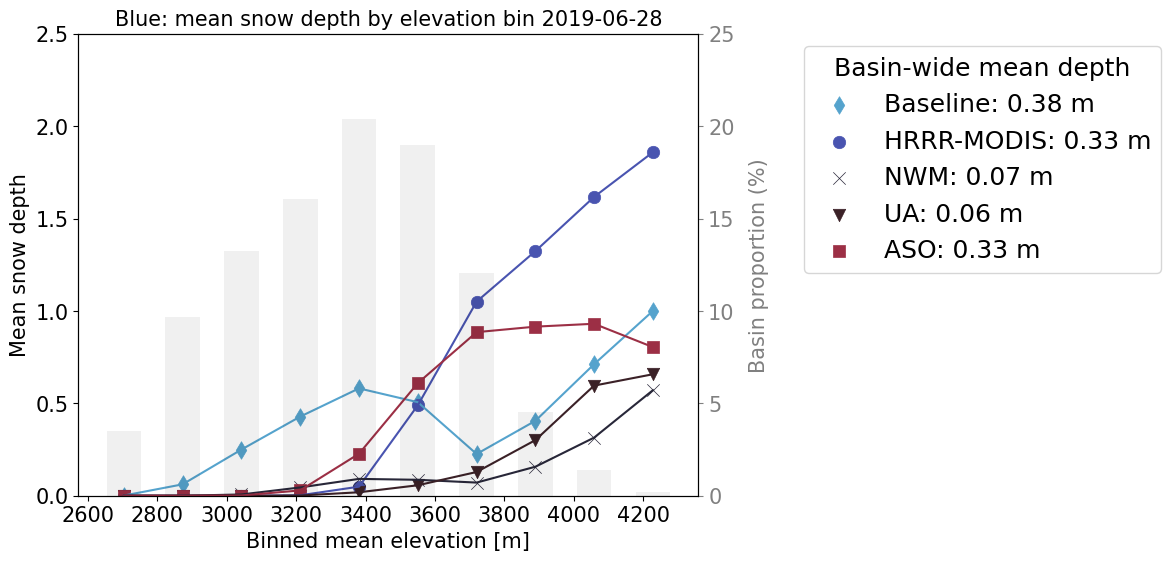

In [113]:

# bin by elevation range
# store the binned and mean values of snow depth difference for that bin in a dict

elev_dict = dict()
# Also plot this up
markerstyles = ['d', 'o', 'x',  'v', 's', 'd', 'P']
fig, ax = plt.subplots(1, figsize=(8, 6))
print('Mean depth by elevation')

if run_aso:
    # Pull the array representing difference from ASO 
    for jdx, k in enumerate(diff_dict.keys()):
        # print('\n', k)
        diff_arr = diff_dict[k].load()
        # Add back in ASO to get the original array, but still clipped to ASO bounds :D
        clip_arr = diff_arr + aso_reproj_list[jdx]
        mean_elevs, mean_depths = plotit(dem_elev_ranges=dem_elev_ranges, 
                                         clip_arr=clip_arr, dem=dem, label=f'{k}',
                                         markerstyle=markerstyles[jdx], depths=True)
        
    # First, plot ASO!
    jdx = jdx + 1
    mean_elevs, mean_depths = plotit(dem_elev_ranges=dem_elev_ranges, 
                                     clip_arr=aso_reproj_list[0], dem=dem, 
                                     markerstyle='s', label='ASO', depths=True)
else:
    # Crop to the same extent as the depth data
    cropped_original_list = [ds.rio.reproject_match(depth) for ds in terrain_list for depth in arrs_original]

    for jdx, k in enumerate(titles[:-1]):
        clip_arr = arrs_original[jdx].load()
        dem_orig = cropped_original_list[jdx]
        mean_elevs, mean_depths = plotit(dem_elev_ranges=dem_elev_ranges, clip_arr=clip_arr, markerstyle=markerstyles[jdx], dem=dem_orig, label=f'{k}', depths=True)
        
ax.legend(bbox_to_anchor=(1.15, 1), title='Basin-wide mean depth')
ax.set_ylim(0, 2.5)
ax.set_ylabel('Mean snow depth')
ax.set_xlabel('Binned mean elevation [m]')
ax.set_title(f'{basin.capitalize()}: mean snow depth by elevation bin {date_list[ddx]}')

# Basin area by elevation 
basinarea_alpha = 0.5
ax2 = ax.twinx()
area_proportion = area_slices / area_slices.sum() * 100
ax2.bar(x=mean_elevs, height=area_proportion, width=100, alpha=0.06, color='k')
ax2.set_ylim(0, 25)

# Add annotation for each area bar
annotate = False
if annotate:
    for idx, area in enumerate(area_slices):
        if idx == 6:
            adjustment = -0.02
        elif idx >= 7:
            adjustment = -area_proportion[idx] + 0.0075
        else:
            adjustment = 0.01
        
        ax2.annotate(f'{area_proportion[idx]:.2f}', xy=(mean_elevs[idx], area_proportion[idx]+adjustment), 
                    ha='center', va='center', color='k', alpha=basinarea_alpha, fontsize=12)
    # # Turn off y ticks for ax2
    # ax2.yaxis.set_ticks([])

ax2.set_ylabel('Basin proportion (%)', labelpad=10, color='k', alpha=basinarea_alpha) 
# change ax2 ticks, tick labels and axis label color
ax2.tick_params(axis='y', colors='gray')
# ax.grid(True, linestyle=':', linewidth=1, color='k', axis='y')
# ax2.grid(True, alpha=0.2)

# rearrange legend items, moving last item to top
handles, labels = ax.get_legend_handles_labels()
handles = handles[-1:] + handles[:-1]


Snow volume by elevation


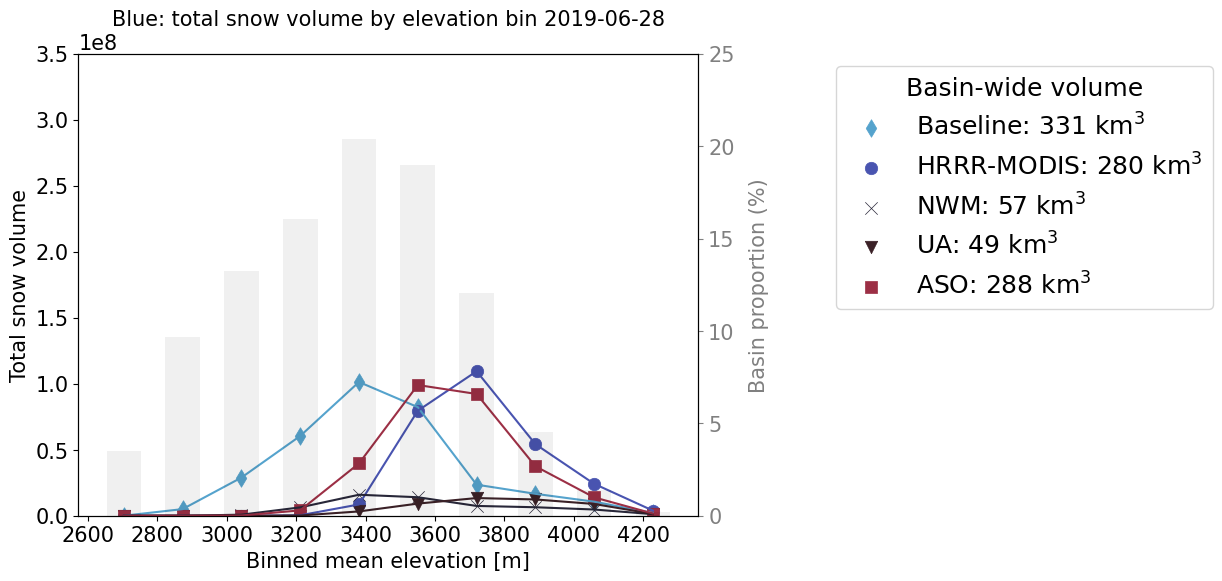

In [114]:
# bin by elevation range
# store the binned and mean values of snow depth difference for that bin in a dict
elev_dict = dict()

# Also plot this up
markerstyles = ['d', 'o', 'x',  'v', 's', 'd', 'P']
# markerstyles = ['s', 'd', 'o', 'x',  'v', 'd', 'P']

fig, ax = plt.subplots(1, figsize=(8, 6))

print('Snow volume by elevation')
if run_aso:
    # Pull the array representing difference from ASO 
    for jdx, k in enumerate(diff_dict.keys()):
        # print('\n', k)
        diff_arr = diff_dict[k].load()
        # Add back in ASO to get the original array, but still clipped to ASO bounds :D
        clip_arr = diff_arr + aso_reproj_list[jdx]
        mean_elevs, total_volumes = plotit(dem_elev_ranges=dem_elev_ranges, clip_arr=clip_arr, label=f'{k}',
                                          dem=dem, pixel_res=pixel_res, markerstyle=markerstyles[jdx], depths=False)
    k = 'ASO'
    jdx = jdx + 1 # fix this in the function in the future, this is how markerstyles get updated and withou
    mean_elevs, total_volumes = plotit(dem_elev_ranges=dem_elev_ranges, clip_arr=aso_reproj_list[0], label=f'{k}',
                                          dem=dem, pixel_res=pixel_res, markerstyle=markerstyles[jdx], depths=False)
    
    
else:
    for jdx, k in enumerate(titles[:-1]):
        # print('\n', k)
        clip_arr = arrs[jdx].load()
        mean_elevs, total_volumes = plotit(dem_elev_ranges=dem_elev_ranges, clip_arr=clip_arr, label=f'{k}',
                                          dem=dem, pixel_res=pixel_res, markerstyle=markerstyles[jdx], depths=False)

ax.legend(bbox_to_anchor=(1.85, 1), title='Basin-wide volume')
ax.set_ylim(0, 3.5e8)
ax.set_ylabel('Total snow volume')
ax.set_xlabel('Binned mean elevation [m]')
ax.set_title(f'{basin.capitalize()}: total snow volume by elevation bin {date_list[ddx]}')

# Basin area by elevation 
basinarea_alpha = 0.5
ax2 = ax.twinx()
ax2.bar(x=mean_elevs, height=area_proportion, width=100, alpha=0.06, color='k')
ax2.set_ylim(0, 25)

# Add annotation for each area bar
annotate = False
if annotate:
    for idx, area in enumerate(area_slices):
        adjustment = 0.01
        if ddx == 0:
            if idx >= 4 and idx <= 6:
                adjustment = None
            elif idx >= 7 and idx < 9:
                adjustment = -area_proportion[idx] + 0.005
            elif idx == 9:
                adjustment = None
        if ddx == 1:
            if idx >= 7:
                adjustment = None
        if adjustment is not None:
            ax2.annotate(f'{area_proportion[idx]:.2f}', xy=(mean_elevs[idx], area_proportion[idx]+adjustment), 
                        ha='center', va='center', color='k', alpha=basinarea_alpha, fontsize=12)
    # # Turn off y ticks for ax2
    # ax2.yaxis.set_ticks([])

ax2.set_ylabel('Basin proportion (%)', labelpad=10, color='k', alpha=basinarea_alpha) 
# change ax2 ticks, tick labels and axis label color
ax2.tick_params(axis='y', colors='gray')
# ax.grid(True, linestyle=':', linewidth=1, color='k', axis='y')
# ax2.grid(True, alpha=0.2)

# # rearrange legend items, moving last item to top
# handles, labels = ax.get_legend_handles_labels()
# handles = handles[-1:] + handles[:-1]


In [115]:
# # np.nansum(nwm_depth.values* 1000 **2) / 1e6
# # np.nansum(swann_depth.values* 4000 **2) / 1e6
# # np.nansum(depths[0].values* 100 **2) / 1e6
# # np.nansum(depths[1].values* 100 **2) / 1e6
# np.nansum(aso_depth_list[1]['snow_depth'].values * 50 **2) / 1e6

In [116]:
df = pd.DataFrame({'low_thresh_elevation_m': low_elevs, 'cumulative_rel_area': total_areas,
                   'total_area_m2': area_slices, 
                   'mean_elevation_m': mean_elevs, 
                   'mean_depth': mean_depths, 'total_volume_m3': total_volumes,
                   'elev_range_m': list(dem_elev_ranges.values())
                   }) 
outname = f'{basin}_hypsometry_{n_bins}bins.csv'
if not os.path.exists(outname):
    df.to_csv(outname, index=False)
df
# df = pd.DataFrame({'mean_elevation_m': mean_elevs, 'cumulative_rel_area': total_areas,
#                    'total_area_m2': area_slices, 
#                    'mean_depth': mean_depths, 'total_volume_m3': total_volumes,
#                    'elev_range_m': list(dem_elev_ranges.values())
#                    }) 
# outname = f'{basin}_hypsometry.csv'
# df.to_csv(outname, index=False)
# df

low_thresh_elevation_m  cumulative_rel_area  total_area_m2  \
0                    2619             1.000000       53570000   
1                    2788             0.965232      149320000   
2                    2957             0.868322      203670000   
3                    3127             0.736137      247240000   
4                    3296             0.575675      314390000   
5                    3466             0.371632      292680000   
6                    3635             0.181678      186010000   
7                    3805             0.060955       69740000   
8                    3974             0.015693       21330000   
9                    4143             0.001850        2840000   

   mean_elevation_m    mean_depth  total_volume_m3  elev_range_m  
0            2703.5  0.000000e+00     0.000000e+00  (2619, 2788)  
1            2872.5  2.325641e-07     1.888188e+01  (2788, 2957)  
2            3042.0  1.072902e-03     1.240919e+05  (2957, 3127)  
3            3211.5  2.880246e-02     4.064316e+06  (3127, 3296)  
4            3381.0  2.272001e-01     3.962370e+07  (3296, 3466)  
5            3550.5  6.092533e-01     9.901584e+07  (3466, 3635)  
6            3720.0  8.851290e-01     9.223044e+07  (3635, 3805)  
7            3889.5  9.149318e-01     3.744816e+07  (3805, 3974)  
8            4058.5  9.305090e-01     1.392041e+07  (3974, 4143)  
9            4228.0  8.042807e-01     1.680946e+06  (4143, 4313)